In [28]:
# First import OpenCV, NumPY and MatPlotLib as we will use these libraries
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import * 
%matplotlib inline


Now we process 1 image to generate its vector.

118 128


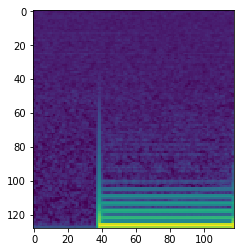

In [29]:
# Let's use starfish.  I've picked up a blurred version of our starfish
# to make it a little easier for K-means to segment into two clusters.

img = Image.open("1000_c.png")
plt.imshow(img)
# Store the image's width and height for later use. 
imgWidth = img.size[0]
imgHeight = img.size[1]

print(imgWidth, imgHeight)

100%|##########| 128/128 [00:00<00:00, 8016.11it/s]


[0.854052   0.8436508  0.8436508  0.8346512  0.8419987  0.8485353
 0.8380558  0.85013825 0.85013825 0.8397427  0.8380558  0.8346512
 0.8248005  0.8397427  0.85670376 0.8452912  0.8397427  0.8419987
 0.8307872  0.8485353  0.8380558  0.83252734 0.8290382  0.8363585
 0.8436508  0.8307872  0.8248005  0.8397427  0.8307872  0.8485353
 0.8520099  0.866303   0.8520099  0.8363585  0.8380558  0.8582389
 0.866303   0.8397427  0.8307872  0.8397427  0.8582389  0.8452912
 0.85670376 0.8346512  0.85013825 0.854052   0.8307872  0.8248005
 0.8346512  0.8731915  0.87049735 0.8363585  0.82728064 0.8212252
 0.869119   0.8582389  0.866303   0.866303   0.8520099  0.81965476
 0.8015021  0.8346512  0.8290382  0.8452912  0.82728064 0.8419987
 0.8452912  0.8040863  0.82728064 0.8346512  0.79334944 0.8128459
 0.8307872  0.80748194 0.81965476 0.8040863  0.8015021  0.8230167
 0.8163003  0.79510105 0.8163003  0.8128459  0.79888064 0.7822377
 0.78121066 0.82728064 0.8582389  0.8181262  0.8346512  0.8023909
 0.790630

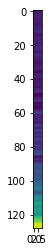

In [30]:
# This is a test on what I treat image as array is as I expected.

rightEdge = np.ndarray(shape=(imgHeight,5, 4), dtype = np.uint8)
avg1=np.ndarray(shape=(imgHeight), dtype = np.float)
avg1=np.float32(avg1)

# You must use float32 here as 'float' does not 
# have to be 32-bit. float32 has to be 32-bit
# and we'll shortly use a routine that needs float32s.
#rightEdge = np.int(rightEdge)

for y in tqdm(range(0, imgHeight), ascii=True):
    for x in range(imgWidth-1, imgWidth):
        xy = (x, y)
        rgb = img.getpixel(xy)
        avg1[y]= 1- np.sqrt(0.299*pow(rgb[2],2) + 0.587*pow(rgb[1],2) + 0.114*pow(rgb[0],2))/np.sqrt(3)/255 # converted to 0-1
        
        for offset in range(0,5):
            rightEdge[y,offset, 0] = rgb[0]           # blue
            rightEdge[y,offset, 1] = rgb[1]           # green
            rightEdge[y,offset,2] = rgb[2]           # red
            rightEdge[y,offset, 3] = rgb[3]          

plt.imsave("rightEdge.png",arr=rightEdge)

plt.imshow(Image.open("rightEdge.png"))

print(avg1)



100%|##########| 128/128 [00:00<00:00, 729.62it/s]


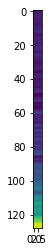

In [31]:
# This is a test on what I average color is as I expected

avgImg = np.ndarray(shape=(imgHeight,5, 4), dtype = np.uint8)

# You must use float32 here as 'float' does not 
# have to be 32-bit. float32 has to be 32-bit
# and we'll shortly use a routine that needs float32s.
#rightEdge = np.int(rightEdge)

for y in tqdm(range(0, imgHeight), ascii=True):
    tempSum=np.zeros(4)
    
    for x in range(int(np.around(imgWidth/2))-1, imgWidth):
        xy = (x, y)
        rgb = img.getpixel(xy)
        tempSum[0] += rgb[0]           # blue
        tempSum[1] += rgb[1]           # green
        tempSum[2] += rgb[2]           # red
        tempSum[3] += rgb[3]          
            
    for offset in range(0,5):
        avgImg[y,offset, 0] =int(np.around( tempSum[0]*2/imgWidth))           # blue
        avgImg[y,offset, 1] =int( np.around(tempSum[1]*2/imgWidth) )          # green
        avgImg[y,offset,2] =int( np.around(tempSum[2]*2/imgWidth) )          # red
        avgImg[y,offset, 3] = int(np.around(tempSum[3]*2/imgWidth)   )       

plt.imsave("avgImg.png",arr=rightEdge)

plt.imshow(Image.open("avgImg.png"))

In [ ]:
# To generate a vector of avg values

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy.cluster.vq as scv
import os
    
def colormap2arr(arr,cmap):    
    # http://stackoverflow.com/questions/3720840/how-to-reverse-color-map-image-to-scalar-values/3722674#3722674
    gradient=cmap(np.linspace(0.0,1.0,100))

    # Reshape arr to something like (240*240, 4), all the 4-tuples in a long list...
    arr2=arr.reshape((arr.shape[0]*arr.shape[1],arr.shape[2]))

    # Use vector quantization to shift the values in arr2 to the nearest point in
    # the code book (gradient).
    code,dist=scv.vq(arr2,gradient)

    # code is an array of length arr2 (240*240), holding the code book index for
    # each observation. (arr2 are the "observations".)
    # Scale the values so they are from 0 to 1.
    values=code.astype('float')/gradient.shape[0]

    # Reshape values back to (240,240)
    values=values.reshape(arr.shape[0],arr.shape[1])
    values=values[::-1]
    return values

In [1]:
def image2Vector(imgname):
    arr=plt.imread(imgname)
    imgWidth = arr.shape[0]
    imgHeight = arr.shape[1]

    #print(imgWidth, imgHeight)

    leftPart=arr[:,int(np.around(imgWidth/2)):(imgWidth-1),:]

    #print(leftPart.shape)

    values=colormap2arr(leftPart,cm.jet)    

    #print(values.shape)

    avgValues=np.mean(values, axis=1, dtype=np.float32)

    #print(avgValues.shape)

    # Proof that it works:
    #plt.imshow(values,interpolation='bilinear', cmap=cm.jet,
    #       origin='lower', extent=[-3,3,-3,3])
    #plt.show()
    
    #print(avgValues)
    
    return avgValues

#image2Vector("1000_c.png")

In [1]:
def image2Vector_Exp(imgname):
    arr=plt.imread(imgname)
    imgWidth = arr.shape[0]
    imgHeight = arr.shape[1]

    #print(imgWidth, imgHeight)

    leftPart=arr[:,int(np.around(imgWidth/2)):(imgWidth-1),:]

    values=colormap2arr(leftPart,cm.jet)    

    #avgValues=np.mean(values, axis=1, dtype=np.float32)

    avgValues=np.log10(np.mean(np.power(10,values)))
    
    return avgValues


In [11]:
import csv

with open('train_labels.csv', newline='') as csvfile:
    id_labels = list(csv.reader(csvfile))

#print(id_labels)

with open('submission_format.csv', newline='') as csvfile:
    id_labels_test = list(csv.reader(csvfile))

#print(id_labels_test)



In [18]:
# Save the data files into a format compatible with CNTK text reader
def save_as_txt(filename, ndarray):
    dir = os.path.dirname(filename)

    if not os.path.exists(dir):
        os.makedirs(dir)

    first=True    
    if not os.path.isfile(filename):
        print("Saving", filename )
        with open(filename, 'w') as f:
            labels = list(map(' '.join, np.eye(11, dtype=np.uint).astype(str))) #11 is the num of kinds we will classify into
            
            for row in ndarray:
                row_str = row.astype(str)
                #print(row[-1])
                #print(type(row[-1]))
                label=np.int(np.round(float(row[-1]),0))
                label_str = labels[label]
                feature_str = ' '.join(row_str[:-1])
                f.write('|labels {} |features {}\n'.format(label_str, feature_str))
                
                if first:
                    #print('|labels {} |features {}\n'.format(label_str, feature_str))
                    #print(label)
                    #print(label_str)
                    first=False
                    #break
    else:
        print("File already exists", filename)

In [19]:
#!/usr/bin/python
def create_pairs(datasource,foldername):
    id_label_arr=np.array(datasource)

    #rows=np.ndarray(shape=(2*imgHeight+1), dtype = np.float)
    rows=np.zeros((2*imgHeight+1,), dtype = np.float)

    first=True

    #print(rows)
    #print("*****************")

    for pair in id_label_arr:

        current_file = os.path.join(".", foldername,str(pair[0])+"_c.png")
        voltage_file= os.path.join(".", foldername,str(pair[0])+"_v.png")
    
        #print(current_file)
        if os.path.exists(current_file) and os.path.exists(voltage_file):
            current_array=image2Vector(current_file)
            #print(current_array[0])
            voltage_array=image2Vector(voltage_file)
            #print(voltage_array[0])
            row=np.hstack((current_array,voltage_array,[pair[1]]))
            #print(row.shape)
        
            if first:
                #print(pair)            
                #print(current_file)
                #print(current_array)
                rows=row
                #print(row)
                first=False
                #break
            else:
                rows=np.concatenate((rows,row), axis=0)
        else:
            print("Missed:"+current_file+", or "+ voltage_file)
        #print(rows.shape)
        #print(rows)

    newRows=rows.reshape(int(rows.shape[0]/257),257)
        #print(newRows.shape)
    return newRows
    
imgHeight=128

# Save the train and test files (prefer our default path for the data)
data_dir = os.path.join(".", "PLAID")

train_pairs=create_pairs(id_labels,"train")
print ('Writing train text file...')
save_as_txt(os.path.join(data_dir, "train.txt"), train_pairs)

test_pairs=create_pairs(id_labels_test,"test")
print ('Writing test text file...')
save_as_txt(os.path.join(data_dir, "test.txt"), test_pairs)

print('Done')

Missed:./train/id_c.png, or ./train/id_v.png
Writing train text file...
Saving ./PLAID/train.txt
Missed:./test/id_c.png, or ./test/id_v.png
Writing test text file...
Saving ./PLAID/test.txt
Done


In [23]:
id_labels

[['id', 'appliance'],
 ['1000', '8'],
 ['1001', '1'],
 ['1002', '8'],
 ['1003', '10'],
 ['1004', '6'],
 ['1005', '1'],
 ['1006', '10'],
 ['1007', '2'],
 ['1008', '0'],
 ['1009', '5'],
 ['1010', '0'],
 ['1011', '3'],
 ['1012', '2'],
 ['1013', '6'],
 ['1014', '4'],
 ['1015', '8'],
 ['1016', '3'],
 ['1017', '5'],
 ['1018', '7'],
 ['1019', '2'],
 ['1020', '0'],
 ['1021', '7'],
 ['1022', '6'],
 ['1023', '2'],
 ['1024', '0'],
 ['1025', '3'],
 ['1026', '0'],
 ['1027', '5'],
 ['1028', '2'],
 ['1029', '1'],
 ['1030', '3'],
 ['1031', '1'],
 ['1032', '5'],
 ['1033', '0'],
 ['1034', '4'],
 ['1035', '9'],
 ['1036', '5'],
 ['1037', '9'],
 ['1038', '10'],
 ['1039', '4'],
 ['1040', '6'],
 ['1041', '1'],
 ['1042', '7'],
 ['1043', '2'],
 ['1044', '0'],
 ['1045', '5'],
 ['1046', '5'],
 ['1047', '4'],
 ['1048', '2'],
 ['1049', '7'],
 ['1050', '8'],
 ['1051', '9'],
 ['1052', '5'],
 ['1053', '3'],
 ['1054', '4'],
 ['1055', '1'],
 ['1056', '5'],
 ['1057', '1'],
 ['1058', '10'],
 ['1059', '10'],
 ['1060', '7'

In [29]:
list(map(' '.join, np.eye(11, dtype=np.uint).astype(str))) 

['1 0 0 0 0 0 0 0 0 0 0',
 '0 1 0 0 0 0 0 0 0 0 0',
 '0 0 1 0 0 0 0 0 0 0 0',
 '0 0 0 1 0 0 0 0 0 0 0',
 '0 0 0 0 1 0 0 0 0 0 0',
 '0 0 0 0 0 1 0 0 0 0 0',
 '0 0 0 0 0 0 1 0 0 0 0',
 '0 0 0 0 0 0 0 1 0 0 0',
 '0 0 0 0 0 0 0 0 1 0 0',
 '0 0 0 0 0 0 0 0 0 1 0',
 '0 0 0 0 0 0 0 0 0 0 1']

In [13]:
np.log10(1110)

3.0453229787866576

In [15]:
import numpy as np
v=[1,2,3]
va=np.array(v)
np.log10(np.mean(np.power(10,v)))

2.568201724066995